### Import libraries

In [136]:
import pandas as pd
import random
from time import sleep
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
%matplotlib inline

### Scrape link directory
Using BeautifulSoup, we'll scrape wildwinds.com/coins/ric/i.html for landing pages of coin subjects  in alphabetical order. As of 11/3/2023, wildwinds.com/robots.txt grants permission for webscraping requests, provided there is a delay of 30 seconds between each request, and that the webscraping software is not explicitly blacklisted.

In [2]:
with requests.get('https://www.wildwinds.com/coins/ric/i.html') as raw:
    soup = BeautifulSoup(raw.content, 'lxml')

### Parse html data for a clean list of ruler names

In [3]:
options = soup.find_all('option')
emperors_raw = [i.contents for i in options if i.attrs['value'] != ''][:-6]
emperors = []
for line in emperors_raw:
    for text in line:
        emperors.append(text.strip())
print(f'First five: {emperors[:5]} \nLast five: {emperors[-5:]} \n{len(emperors)} emperors total')

First five: ['Aelia Ariadne', 'Aelia Flacilla', 'Aelia Verina', 'Aelius', 'Aemilian'] 
Last five: ['Vitellius', 'Volusian', 'Zeno', 'Zenobia', 'Zenonis'] 
231 emperors total


### Generate list of usable link roots for each Emperor's coin page

In [4]:
# wildwinds.com/robots.txt requires a 30-second delay between requests
linkroots = ['https://www.wildwinds.com/coins/ric/' + i.attrs['value'][:-6] for i in options if i.attrs['value'] != ''][:-6]
print(f'First five: {linkroots[:5]} \nLast five: {linkroots[-5:]} \n{len(linkroots)} linkroots total')

First five: ['https://www.wildwinds.com/coins/ric/aelia_ariadne/', 'https://www.wildwinds.com/coins/ric/aelia_flaccilla/', 'https://www.wildwinds.com/coins/ric/aelia_verina/', 'https://www.wildwinds.com/coins/ric/aelius/', 'https://www.wildwinds.com/coins/ric/aemilian/'] 
Last five: ['https://www.wildwinds.com/coins/ric/vitellius/', 'https://www.wildwinds.com/coins/ric/volusian/', 'https://www.wildwinds.com/coins/ric/zeno/', 'https://www.wildwinds.com/coins/ric/zenobia/', 'https://www.wildwinds.com/coins/ric/zenonis/'] 
231 linkroots total


### Create a semi-random list of test pages for building an adaptable parser

In [26]:
test_ids = random.choices(range(len(linkroots)), k=10) # 10 random index numbers
test_roots = [linkroots[i] for i in test_ids] # Corresponding url roots
for root in test_roots:
    print(root)

https://www.wildwinds.com/coins/ric/commodus/
https://www.wildwinds.com/coins/ric/volusian/
https://www.wildwinds.com/coins/ric/valentinian_II/
https://www.wildwinds.com/coins/ric/valerius_valens/
https://www.wildwinds.com/coins/ric/carus/
https://www.wildwinds.com/coins/ric/galba/
https://www.wildwinds.com/coins/ric/severus_III/
https://www.wildwinds.com/coins/ric/tranquillina/
https://www.wildwinds.com/coins/ric/julia_mamaea/
https://www.wildwinds.com/coins/ric/gratian/


### pull html from test pages

In [56]:
# Define function that scrapes indicated pages with 30-second delay between requests
def scrape(url_roots: list[str]):
    combined_pages_html = []
    max_length = 0
    for root in url_roots:
        sleep(30)
        url = root + 'i.html'
        message = f'requesting {url} ({url_roots.index(root) + 1}/{len(url_roots)})'
        max_length = max(max_length, len(message))
        print(f'\r{message.ljust(max_length)}', end=' ', flush=True)
        page_html = requests.get(url)
        combined_pages_html.append(page_html)
    # After the loop, print a final message that clears the last line
    print(f'\rscraping complete: {url_roots.index(root) + 1}/{len(url_roots)}'.ljust(max_length))
    return combined_pages_html

In [57]:
# Scrape test pages' html (this takes some time with the delay)
test_pages = scrape(test_roots)

scraping complete: 10/10                                                     


### Inspect test page html

In [101]:
# Convert page html into easier-to-manipulate format using BeautifulSoup
test_soups = [BeautifulSoup(page.content, 'lxml') for page in test_pages]

In [116]:
print(f'Test soup preview: \n\n{str(test_soups[5])[:2000]}')

Test soup preview: 

<html>
<head>
<title>Galba, Roman Imperial Coins reference at WildWinds.com</title>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<base target="_parent"/>
</head>
<body bgcolor="#D7D5D5">
<object data="https://www.wildwinds.com/coins/topscript.html" height="160" width="100%"></object><br/>
<center>
<p></p><h2>Browsing Roman Imperial Coins of Galba</h2>
<p><img src="toppic.jpg"/>
<br/><font size="2"><h3>Galba, AD 68-69.</h3>
</font></p><h3><a href="t.html">Browse the Galba page with thumbnail images.</a></h3>
<br/><b>BEWARE OF NUMEROUS MODERN BULGARIAN FAKE GALBA SESTERTII - OFTEN OF THE LIBERTAS PVBLICA TYPE - SOLD BY UNSCRUPULOUS SELLERS ON EBAY ETC. AND ALSO BEING OFFERED IN PERSON TO DEALERS ALL OVER EUROPE.</b>
<table border="1" cellpadding="0" cellspacing="1">
<tr><td bgcolor="#B7A642">Kraay 46</td><td>Galba, AE sestertius, Rome, officina A. AD 68. 34.2 mm, 27.88 g. SER GALBA IMP CAES AVG P M TR P, laureate head right. / Livia, draped, 

### Create helper functions for parsing data fields

In [98]:
# Define function for parsing names of coin subjects
def pull_title(soup):
    raw_title = soup.find('title').text
    sep_index = raw_title.find(',')
    if sep_index == -1:
        sep_index = raw_title.find('-')
    return raw_title[:sep_index].strip() if sep_index != -1 else raw_title.strip()

In [103]:
# Function to test pull_title()
def test_pull_title(soups): 
    titles = pd.Series([pull_title(soup) for soup in soups])
    print(f'Out of {len(soups)} soups, {titles.isna().sum()} have missing titles.')
    print(titles.tolist())

In [100]:
test_pull_title(test_soups)

Out of 10 soups, 0 have missing titles.
['Commodus', 'Volusian', 'Valentinian II', 'Valerius Valens', 'Carus', 'Galba', 'Severus III (Libius Severus)', 'Tranquillina', 'Julia Mamaea', 'Gratian']


In [105]:
# Function to pull subtitles
def pull_subtitle(soup):
    possible_locations = [
        lambda s: s.find_all('h3')[0].contents[-1],
        lambda s: s.find('font').contents[0],
        lambda s: s.find_all('p')[1].contents[-1],
        lambda s: s.find_all('br')[0].contents[0],
    ]
    
    for get_subtitle in possible_locations:
        try:
            subtitle = get_subtitle(soup)
            if not subtitle or len(str(subtitle)) < 4:
                continue
            if any(keyword in str(subtitle) for keyword in ['Click', 'Browse']):
                continue
            if '(' in str(subtitle) or '<' in str(subtitle):
                return None
            return str(subtitle).strip()
        except (IndexError, AttributeError):
            continue 
    
    return None

In [106]:
# Function to test pull_subtitle()
def test_pull_subtitle(soups):
    subtitles = pd.Series([pull_subtitle(soup) for soup in soups])
    print(f'Out of {len(soups)} soups, {subtitles.isna().sum()} have missing subtitles.')
    print(subtitles.tolist()) 

In [107]:
test_pull_subtitle(test_soups)

Out of 10 soups, 7 have missing subtitles.
['Commodus, Caesar 172-179, Augustus 179-192 AD.', None, None, None, 'Carus, 282-283 AD', 'Galba, AD 68-69.', None, None, None, None]


### Function to pull raw coin data

In [143]:
def pull_coins(soup):
    coins = [coin.contents for coin in soup.find_all('tr') if len(coin) >2 and 'bgcolor' in str(coin)]
    return coins

In [152]:
print('raw coin data:\n')
pp = pprint.PrettyPrinter(compact=True)
pp.pprint(pull_coins(test_soups[7])[:5])

raw coin data:

[[<td bgcolor="#C0C0C0">RIC 249</td>,
  <td>Tranquillina. AR Antoninianus, Rome, AD 241. 4.54 g. SABINIA TRANQVILLINA AVG, diademed and draped bust right, on crescent. / CONCORDIA AVGG, Concordia seated left, holding patera and double cornucopiae. RIC IV 249; RSC 1.</td>,
  <td><a href="RIC_0249.txt">Text</a></td>,
  <td><a href="RIC_0249.jpg">Image</a></td>],
 [<td bgcolor="#C0C0C0">RIC 250 <br/>Sear5 #8866</td>,
  <td><a href="../../sear5/s8866.html#RIC_0250">Tranquillina AR Antoninianus. Struck AD 241. SABINA TRANQVILLINA AVG, diademed draped bust right, set on crescent / CONCORDIA AVGG, Gordian III standing right, holding a roll in his left hand, clasping hand of Tranquillina standing left. RIC 250, RSC 4.</a></td>,
  '\n', <th colspan="2"><font size="-2">(One example)</font></th>],
 [' ', <td bgcolor="#C0C0C0">RIC 252 <br/>Sear5 #8867</td>,
  <td><a href="../../sear5/s8867.html#RIC_0252">Tranquillina Denarius. Struck 241 AD. SABINIA TRANQVILLINA AVG, diademed drape

### Helper functions to parse useful data features

In [147]:
# Function to identify coin metal
def coin_metal(coin):
    metals = {'#B8':'Copper','#b8':'Copper', '#FF':'Gold', '#C0':'Silver', '#B7':'Brass', '#b7':'Brass', 'red':'FAKE'}
    try:
        bg_color_index = int(str(coin).find('bgcolor=')) + 9
        bg_color = str(coin)[bg_color_index:bg_color_index + 3]
        metal = metals[bg_color]
    except:
        return None
    return metal

In [153]:
# Function to pull coin era (i.e. 'AD' or 'BC') 
def coin_era(coin):
    coin = str(coin)
    if 'AD' in coin:
        return 'AD'
    elif 'BC' in coin:
        return 'BC'
    else:
        return None

# Function to pull a year (not *every* year) in the coin description
# (if there is a range of years i.e. 117-124 AD, function pulls the year closest to era i.e. '117-124 AD' returns '124', while 'AD 117-124' returns '117')
def coin_year(coin):
    era = coin_era(coin)
    coin = str(coin)
    year = 0
    try:
        index = coin.find(coin_era(coin))
    except TypeError:
        return None
    if coin[index - 2].isnumeric():
        if coin[index - 3].isnumeric():
            if coin[index - 4].isnumeric():
                year += int(coin[index-4:index-1])
            else:
                year += int(coin[index-3:index-1])
        else:
            year += int(coin[index-2])
    elif coin[index + 3].isnumeric():
        if coin[index + 4].isnumeric():
            if coin[index + 5].isnumeric():
                year += int(coin[index+3:index+6])
            else:
                year += int(coin[index+3:index+4])
        else:
            year += int(coin[index+3])
    if era == 'AD':
        return year
    elif era == 'BC':
        return -year
    elif era == None:
        return None

wildwinds.com/robots.txt forbids use of their images, so those urls will not be parsed

In [19]:
# Function to pull .txt urls
def coin_txt(coin):
    for item in coin:
        item = str(item)
        if '.txt' in item:
            start, end = item.find('href=')+6, item.find('.txt')+4
            return item[start:end]

### use code from above functions to create a crude function to pull coin_id from links

In [20]:
def coin_id(coin):
    coin = str(coin)
    if '.jpg' in coin:
        start, end = coin.rfind('href=')+6, coin.rfind('.jpg')
        return coin[start:end]
    elif '.txt' in coin:
        start, end = coin.rfind('href=')+6, coin.rfind('.txt')
        return coin[start:end]
    else:
        return None

### Create function for coin mass in grams

In [21]:
def coin_mass(coin):
    coin = str(coin)
    # might be able to clean this up by creating a list of possible gram abbreviations and looping through it
    if 'g.' in coin:
        start = coin.find('g.')
        if coin[start-1].isnumeric() or coin[start-2].isnumeric():
            grams = 'g.'
    elif 'g,' in coin:
        start = coin.find('g,')
        if coin[start-1].isnumeric() or coin[start-2].isnumeric():
            grams = 'g,'
    elif 'gm.' in coin:
        grams = 'gm.'
    elif 'gr.' in coin:
        grams = 'gr.'
    elif 'grs,' in coin:
        grams = 'grs,'
    elif 'grs.' in coin:
        grams = 'grs.'
    else:
        return None
    try:
        start = coin.find(grams)
        if coin[start-1].isnumeric():
            if coin[start-2] == '.':
                if coin[start-4].isnumeric():
                    return float(coin[start-4:start])
                else:
                    return float(coin[start-3:start])
        elif coin[start-3] == '.':
            if coin[start-5].isnumeric():
                return float(coin[start-5:start-1])
            else:
                return float(coin[start-4:start-1])
        else:
            if coin[start-6].isnumeric():
                return float(coin[start-6:start-1])
            else:
                return float(coin[start-5:start-1])
    except:
        return None

### Create function for coin size in mm

In [22]:
def coin_diameter(coin):
    coin = str(coin)
    if 'mm' in coin:
        start = coin.find('mm')
        # if there's no space between value and 'mm'
        if coin[start-1].isnumeric():
            if coin[start-2].isnumeric():
                # if value contains a decimal
                if coin[start-3] == '.': 
                    if coin[start-5:start-3].isnumeric():
                        return float(coin[start-5:start])
                    else:
                        return None
                else:
                    return float(coin[start-2:start])
            # if value contains a decimal
            elif coin[start-2] == '.':
                if coin[start-4:start-2].isnumeric():
                    return float(coin[start-4:start])
                else:
                    return None
        # if there is a space between value and 'mm'
        elif coin[start-1] == ' ' and coin[start-2].isnumeric():
            if coin[start-3].isnumeric():
                # if value contains a decimal
                if coin[start-4] == '.':
                    if coin[start-6:start-4].isnumeric():
                        return float(coin[start-6:start-1])
                    else:
                        return None
                else:
                    return float(coin[start-3:start-1])
            elif coin[start-3] == '.':
                if coin[start-5:start-3].isnumeric():
                    return float(coin[start-5:start-1])
                else:
                    return None


### Check for common inscriptions
...such as "AVG" (Augustus, title of the emperor), "IMP" (Imperator (victorious general), received upon accession), "CAES" (Caesar, inherited name of the Julian family (Julius Caesar), used by later emperors to designate heir), "GERM" (Germanicus, a title honoring military victories in Germany), "COS" or "CONSVL" (Consul, a title linked to highest office in Senate, usually held by emperor), "PO" (Pontifex Maximus, highest priest, the head of state religion), "PP" (Pater Patriae, father of the country), "PF" (Pius Felix, reverent or dutiful), "SC" (Senatus Consultus), "TPP" (Tribunica Potestate, tribune of the people, each renewal indicated by numerals), "CENS" (Censor, a public office overseeing taxes, morality, the census and membership in various orders), "BRIT" (Britannicus).

In [23]:
def coin_inscriptions(coin):
    coin = str(coin)
    inscriptions_list = ['AVG', 'IMP', 'CAES', 'GERM', 'COS', 'CONSVL', 'PP', 'PO', 'PF', \
                         'SC', 'CENS', 'TPP', 'TR', 'RESTITVT', 'BRIT', 'AVGVSTVS', 'CAESAR', 
                         'C', 'TRIB POT', 'PON MAX', 'PM']
    coin_inscriptions = []
    for i in inscriptions_list:
        if str(' ' + i + ' ') in coin:
            coin_inscriptions.append(i)
    if len(coin_inscriptions) > 0:
        return coin_inscriptions
    else:
        return None

def unique_inscriptions(inscriptions):
    u_inscriptions = []
    for i in inscriptions:
        try:
            for abb in i:
                if abb not in u_inscriptions:
                    u_inscriptions.append(abb)
        except TypeError:
            continue
    return u_inscriptions

### Create coin_tests() for a basic summary of function success

In [24]:
def coin_tests(soups=test_soups):
    test_coins = []
    for s in soups:
        for c in pull_coins(s):
            test_coins.append(c)
    print(f'Out of {len(test_coins)} coins in {len(soups)} soups, there are:')
    metals = pd.Series([coin_metal(coin) for coin in test_coins])
    print(f'  {metals.isna().sum()} missing metal values')
    print(f'    {metals.nunique()} unique metal values: {metals.unique()}')
    years = pd.Series([coin_year(coin) for coin in test_coins])
    print(f'  {years.isna().sum()} missing year values')
    print(f'    {years.nunique()} unique year values')
    print(f'      Mean: {years.mean()}, Median: {years.median()}, Min: {years.min()}, Max: {years.max()}')
    ids = pd.Series([coin_id(coin) for coin in test_coins])
    print(f'  {ids.isna().sum()} missing id values')
    print(f'    {ids.nunique()} unique id values')
    mass = pd.Series([coin_mass(coin) for coin in test_coins])
    print(f'  {mass.isna().sum()} missing mass values')
    print(f'    {mass.nunique()} unique mass values')
    print(f'      Mean: {mass.mean()}, Median: {mass.median()}, Min: {mass.min()}, Max: {mass.max()}')
    diameter = pd.Series([coin_diameter(coin) for coin in test_coins])
    print(f'  {diameter.isna().sum()} missing diameter values')
    print(f'    {diameter.nunique()} unique diameter values')
    print(f'      Mean: {diameter.mean()}, Median: {diameter.median()}, Min: {diameter.min()}, Max: {diameter.max()}')
    inscriptions = [coin_inscriptions(c) for c in test_coins]
    print(f'  {pd.Series(inscriptions).isna().sum()} missing inscriptions values')
    print(f'    {len(unique_inscriptions(inscriptions))} unique inscriptions')
    print(f'      {unique_inscriptions(inscriptions)}')

coin_tests()

Out of 2593 coins in 10 soups, there are:
  6 missing metal values
    5 unique metal values: ['Gold' 'Copper' 'Silver' 'Brass' None 'FAKE']
  1045 missing year values
    108 unique year values
      Mean: 108.24612403100775, Median: 177.0, Min: -225.0, Max: 570.0
  285 missing id values
    2163 unique id values
  1951 missing mass values
    529 unique mass values
      Mean: 11.673823987538942, Median: 8.67, Min: 0.655, Max: 71.7
  2433 missing diameter values
    46 unique diameter values
      Mean: 23.6601875, Median: 22.0, Min: 14.0, Max: 38.7
  1316 missing inscriptions values
    18 unique inscriptions
      ['AVG', 'IMP', 'TR', 'C', 'CAES', 'PF', 'PM', 'SC', 'PP', 'GERM', 'AVGVSTVS', 'CAESAR', 'COS', 'PO', 'PON MAX', 'TRIB POT', 'BRIT', 'RESTITVT']


## Combine individual coin parsing functions into one that returns a Dataframe
i.e. coin_df(soup)

In [25]:
def coin_df(soup):
    title = pull_title(soup)
    id, metal, mass, diameter, era, year, inscriptions, jpg, txt = [], [], [], [], [], [], [], [], []
    for coin in pull_coins(soup):
        id.append(coin_id(coin))
        metal.append(coin_metal(coin))
        mass.append(coin_mass(coin))
        diameter.append(coin_diameter(coin))
        era.append(coin_era(coin))
        year.append(coin_year(coin))
        inscriptions.append(coin_inscriptions(coin))
        jpg.append(coin_jpg(coin))
        txt.append(coin_txt(coin))
    return pd.DataFrame({'title':title, 'id':id, 'metal':metal, 'mass':mass, 'diameter':diameter, \
                         'era':era, 'year':year, 'inscriptions':inscriptions, 'jpg':jpg, 'txt':txt})

In [26]:
coin_df(test_soups[2]).head()

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
0,Agrippina II,Cohen_01,Brass,NaN,NaN,AD,5.0,[AVG],Cohen_01.jpg,Cohen_01.txt
1,Agrippina II,Cohen_01_countermarked,Brass,14.78,28.0,None,NaN,[AVG],Cohen_01_countermarked.jpg,Cohen_01_countermarked.txt
2,Agrippina II,RIC_0075,Silver,NaN,NaN,AD,54.0,"[CAES, GERM]",RIC_0075.jpg,RIC_0075.txt
3,Agrippina II,None,Brass,NaN,NaN,None,NaN,[AVG],None,None
4,Agrippina II,RIC_0103note,Brass,NaN,NaN,AD,54.0,[AVG],RIC_0103note.jpg,RIC_0103note.txt


## Create a function to combine multiple Dataframes

In [27]:
def combine_coin_dfs(soups):
    dfs = [coin_df(soup) for soup in soups]
    return pd.concat(dfs, ignore_index=True) 

In [28]:
len(combine_coin_dfs(test_soups))

2593

# Switch to working with full data

## Pull html from all source pages
(pulling from over 200 pages, which can take a few minutes)

In [29]:
pages_raw = [requests.get(linkroots[i] + 'i.html') for i in range(len(linkroots))]

In [30]:
all_soups = [BeautifulSoup(pages_raw[i].content, 'lxml') for i in range(len(pages_raw))]

#### Run tests

In [31]:
pull_title_test(all_soups)
pull_subtitle_test(all_soups)
coin_tests(all_soups)

Out of 231 soups, 0 have missing titles.
Out of 231 soups, 79 have missing subtitles.
Out of 40863 coins in 231 soups, there are:
  820 missing metal values
    5 unique metal values: ['Gold' 'Copper' 'Silver' 'Brass' None 'FAKE']
  16423 missing year values
    504 unique year values
      Mean: 203.95040916530277, Median: 217.0, Min: -853.0, Max: 956.0
  2385 missing id values
    33403 unique id values
  31714 missing mass values
    2476 unique mass values
      Mean: 9.99691474478085, Median: 7.5, Min: 0.32, Max: 516.0
  35481 missing diameter values
    478 unique diameter values
      Mean: 23.528050910442214, Median: 23.0, Min: 0.0, Max: 98.0
  23125 missing inscriptions values
    20 unique inscriptions
      ['AVG', 'COS', 'TR', 'CAESAR', 'TRIB POT', 'C', 'IMP', 'CAES', 'PF', 'PM', 'SC', 'PP', 'GERM', 'AVGVSTVS', 'PO', 'PON MAX', 'RESTITVT', 'BRIT', 'CONSVL', 'CENS']


## Combine it all into a single Dataframe

In [32]:
roman_coins_raw = combine_coin_dfs(all_soups)

### Check data quality

In [33]:
roman_coins_raw.head(10)

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
0,Aelia Ariadne,RIC_0933a,Gold,1.46,14.0,AD,491,None,RIC_0933a.jpg,RIC_0933a.txt
1,Aelia Ariadne,RIC_933v,Gold,1.47,15.0,AD,491,None,RIC_933v.jpg,RIC_933v.txt
2,Aelia Ariadne,RIC_0933var2,Gold,4.47,NaN,AD,474,None,RIC_0933var2.jpg,RIC_0933var2.txt
3,Aelia Ariadne,RIC_0938,Gold,1.47,NaN,AD,474,None,RIC_0938.jpg,RIC_0938.txt
4,Aelia Flaccilla,_alexandria_RIC_017,Copper,NaN,NaN,None,NaN,None,_alexandria_RIC_017.jpg,_alexandria_RIC_017.txt
5,Aelia Flaccilla,_antioch_RIC_054,Copper,NaN,NaN,None,NaN,None,_antioch_RIC_054.jpg,_antioch_RIC_054.txt
6,Aelia Flaccilla,_antioch_RIC_061,Copper,NaN,NaN,None,NaN,None,_antioch_RIC_061.jpg,_antioch_RIC_061.txt
7,Aelia Flaccilla,_antioch_RIC_061_G,Copper,NaN,NaN,None,NaN,None,_antioch_RIC_061_G.jpg,_antioch_RIC_061_G.txt
8,Aelia Flaccilla,"_antioch_RIC_062,D",Copper,NaN,NaN,None,NaN,None,"_antioch_RIC_062,D.jpg","_antioch_RIC_062,D.txt"
9,Aelia Flaccilla,_antioch_RIC_062,Copper,NaN,22.0,None,NaN,None,_antioch_RIC_062.jpg,_antioch_RIC_062.txt


In [34]:
roman_coins_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40863 entries, 0 to 40862
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         40863 non-null  object
 1   id            38478 non-null  object
 2   metal         40043 non-null  object
 3   mass          9149 non-null   object
 4   diameter      5382 non-null   object
 5   era           24440 non-null  object
 6   year          24440 non-null  object
 7   inscriptions  17738 non-null  object
 8   jpg           38476 non-null  object
 9   txt           38477 non-null  object
dtypes: object(10)
memory usage: 3.1+ MB


In [35]:
roman_coins_raw.describe()

,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
count,40863,38478,40043,9149.0,5382.0,24440,24440.0,17738,38476,38477
unique,225,33403,5,2476.0,478.0,2,504.0,441,33302,33299
top,Caracalla,RIC_0025,Copper,2.9,18.0,AD,193.0,[PF],RIC_0013.jpg,RIC_0013.txt
freq,2417,23,28907,39.0,360.0,23904,1035.0,2205,24,24


In [36]:
roman_coins_raw.drop_duplicates(subset=['id'], keep='first', inplace=True)

In [37]:
roman_coins = roman_coins_raw.copy()
roman_coins['metal'].fillna('None')
roman_coins['era'].fillna('None')
metal_categories = ['None', 'FAKE', 'Brass', 'Copper', 'Silver', 'Gold']
era_categories = ['None', 'BC', 'AD']
roman_coins['metal'] = pd.Categorical(roman_coins['metal'], categories=metal_categories, ordered=True)
roman_coins['era'] = pd.Categorical(roman_coins['era'], categories=era_categories, ordered=True)
roman_coins['mass'] = roman_coins['mass'].astype('float64')
roman_coins['diameter'] = roman_coins['diameter'].astype('float64')
roman_coins['year'] = roman_coins['year'].astype('float64')

In [38]:
roman_coins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33404 entries, 0 to 40862
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   title         33404 non-null  object  
 1   id            33403 non-null  object  
 2   metal         32765 non-null  category
 3   mass          8282 non-null   float64 
 4   diameter      4651 non-null   float64 
 5   era           19763 non-null  category
 6   year          19763 non-null  float64 
 7   inscriptions  11685 non-null  object  
 8   jpg           33402 non-null  object  
 9   txt           33402 non-null  object  
dtypes: category(2), float64(3), object(5)
memory usage: 2.4+ MB


In [39]:
roman_coins.describe()

,mass,diameter,year
count,8282.000000,4651.000000,19763.000000
mean,10.096173,23.588293,214.178364
std,10.443645,6.141140,111.763026
min,0.320000,0.000000,-853.000000
25%,4.100000,19.000000,161.000000
50%,7.680000,23.000000,222.000000
75%,13.077500,27.000000,305.000000
max,516.000000,98.000000,956.000000


#### Create a filtered dataset for coins with 'year' values

In [40]:
roman_coins_years = roman_coins.dropna(subset=['metal', 'year'])
roman_coins_years = roman_coins_years[roman_coins_years['year']>float(-45.0)]
roman_coins_years = roman_coins_years[roman_coins_years['year']<float(500)]
roman_coins_years.sort_values(by='year').head()


,title,id,metal,mass,diameter,era,year,inscriptions,jpg,txt
29160,Octavia,RPC_2574,Copper,0.93,NaN,BC,-43.0,None,RPC_2574.jpg,RPC_2574.txt
2546,Augustus,RPC_0518,Copper,NaN,NaN,BC,-40.0,None,RPC_0518.jpg,RPC_0518.txt
2547,Augustus,RPC_0620,Brass,18.92,30.0,BC,-38.0,[CAESAR],RPC_0620.jpg,RPC_0620.txt
2548,Augustus,RPC_0621,Brass,15.78,30.0,BC,-38.0,None,RPC_0621.jpg,RPC_0621.txt
2856,Augustus,RPC_5421,Copper,NaN,18.0,BC,-38.0,None,RPC_5421.jpg,RPC_5421.txt


Text(0.5, 1.0, 'Number of Coins by Year')

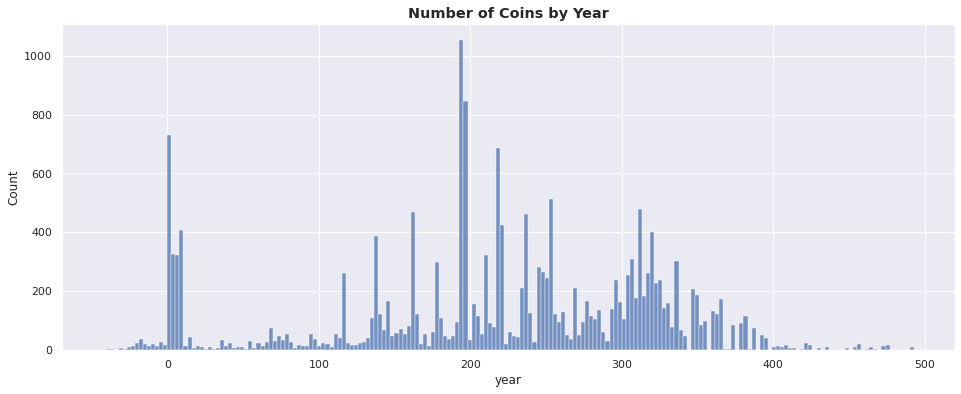

In [43]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(16,6))
sns.histplot(roman_coins_years, x='year', bins=200)
ax.set_title('Number of Coins by Year', fontdict={'weight': 'bold', 'size': 'large'})

<AxesSubplot: xlabel='year'>

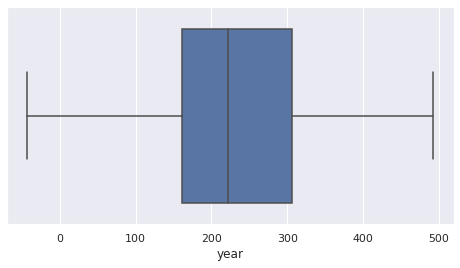

In [48]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(roman_coins_years, x='year')

#### Create a filtered dataset for coins with 'mass' values

In [50]:
roman_coins_mass = roman_coins.dropna(subset=['metal', 'mass'])
pd.to_numeric(roman_coins_mass['mass']).describe(percentiles=[.001, .01, .05, .25, .5, .75, .95, .99, .999])

count    8174.000000
mean       10.160855
std        10.476033
min         0.320000
0.1%        0.612110
1%          1.237300
5%          2.200000
25%         4.120000
50%         7.765000
75%        13.140000
95%        25.563500
99%        41.816200
99.9%      65.708940
max       516.000000
Name: mass, dtype: float64

Remove coins that fall outside the first and last tenths of a percentile

In [51]:
roman_coins_mass = roman_coins_mass.query('mass>.6 and mass<66')
pd.to_numeric(roman_coins_mass['mass']).describe()

count    8157.000000
mean       10.020395
std         8.084833
min         0.670000
25%         4.130000
50%         7.770000
75%        13.120000
max        65.920000
Name: mass, dtype: float64

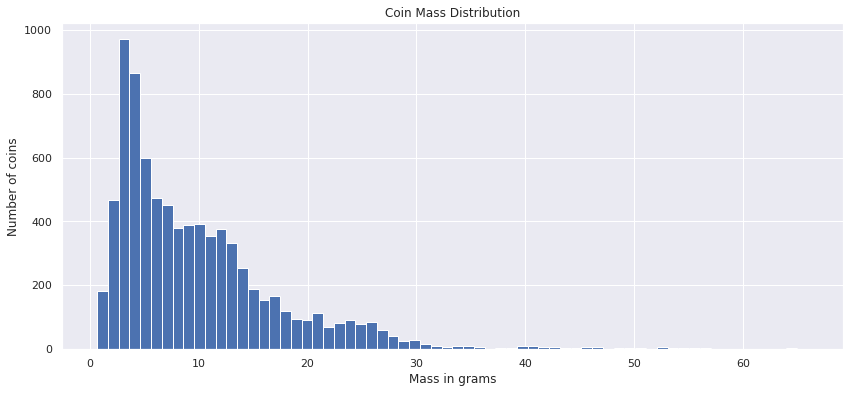

In [55]:
plt.figure(figsize=(14, 6))
plt.hist(x=roman_coins_mass['mass'], bins=66)
plt.title('Coin Mass Distribution'); plt.xlabel('Mass in grams'); plt.ylabel('Number of coins')
plt.show()

In [98]:
roman_coins_metals = roman_coins_raw.copy()
roman_coins_metals.dropna(subset='metal', inplace=True)
roman_coins_metals = roman_coins_metals[roman_coins_metals['metal'] != 'FAKE'].reset_index()
roman_coins_metals['era'].fillna('None')
metal_categories = ['Brass', 'Copper', 'Silver', 'Gold']
era_categories = ['None', 'BC', 'AD']
roman_coins_metals['metal'] = pd.Categorical(roman_coins_metals['metal'], categories=metal_categories, ordered=True)
roman_coins_metals['era'] = pd.Categorical(roman_coins_metals['era'], categories=era_categories, ordered=True)
roman_coins_metals['mass'] = roman_coins_metals['mass'].astype('float64')
roman_coins_metals['diameter'] = roman_coins_metals['diameter'].astype('float64')
roman_coins_metals['year'] = roman_coins_metals['year'].astype('float64')
roman_coins_metals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32761 entries, 0 to 32760
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   index         32761 non-null  int64   
 1   title         32761 non-null  object  
 2   id            32760 non-null  object  
 3   metal         32761 non-null  category
 4   mass          8173 non-null   float64 
 5   diameter      4434 non-null   float64 
 6   era           19323 non-null  category
 7   year          19323 non-null  float64 
 8   inscriptions  11521 non-null  object  
 9   jpg           32759 non-null  object  
 10  txt           32759 non-null  object  
dtypes: category(2), float64(3), int64(1), object(5)
memory usage: 2.3+ MB


<AxesSubplot: >

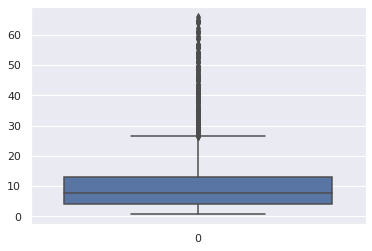

In [92]:
sns.boxplot(roman_coins_metals['mass'])

In [93]:
mass_percentile_25 = roman_coins_metals['mass'].quantile(0.25)
mass_percentile_75 = roman_coins_metals['mass'].quantile(0.75)
mass_iqr = mass_percentile_75 - mass_percentile_25
upper_limit = mass_percentile_75 + 1.5 * mass_iqr
lower_limit = mass_percentile_25 - 1.5 * mass_iqr
print('lower limit', lower_limit, 'upper limit:', upper_limit)

lower limit -9.34 upper limit: 26.599999999999998


#### Since lower limit is negative, we can ignore the lower limit and simply set an upper limit

In [102]:
roman_coins_metals = roman_coins_metals[roman_coins_metals['mass'] < 26.6].reset_index()
roman_coins_metals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7848 entries, 0 to 7847
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   level_0       7848 non-null   int64   
 1   index         7848 non-null   int64   
 2   title         7848 non-null   object  
 3   id            7848 non-null   object  
 4   metal         7848 non-null   category
 5   mass          7848 non-null   float64 
 6   diameter      1780 non-null   float64 
 7   era           6132 non-null   category
 8   year          6132 non-null   float64 
 9   inscriptions  2078 non-null   object  
 10  jpg           7848 non-null   object  
 11  txt           7847 non-null   object  
dtypes: category(2), float64(3), int64(2), object(5)
memory usage: 628.9+ KB


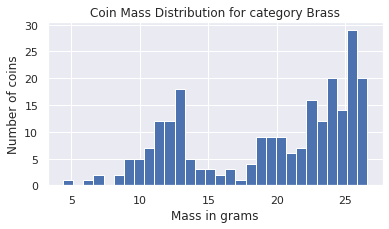

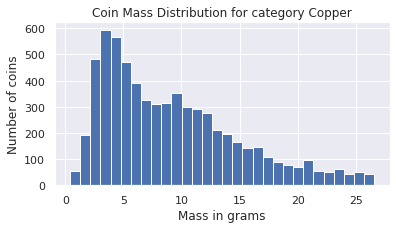

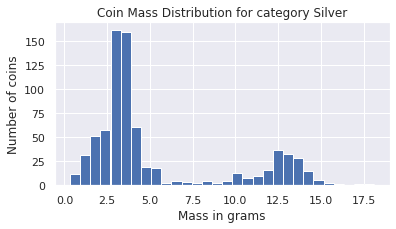

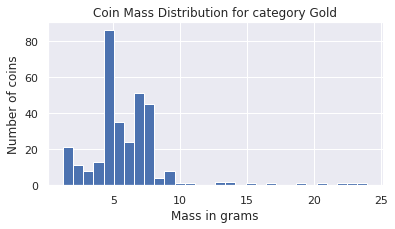

In [111]:

grouped = roman_coins_metals.groupby('metal')

for name, group in grouped:
    plt.figure(figsize=(6, 3))
    plt.hist(x=group['mass'], bins=30)
    plt.title(f'Coin Mass Distribution for category {name}')
    plt.xlabel('Mass in grams')
    plt.ylabel('Number of coins')
    plt.show()

#### Check distribution of the (limited) diameter values

In [71]:
pd.to_numeric(roman_coins['diameter'].dropna()).describe(percentiles=[.001, .01, .05, .25, .5, .75, .95, .99, .999])

count    4631.000000
mean       23.597925
std         6.149481
min         0.000000
0.1%       10.000000
1%         12.000000
5%         15.000000
25%        19.000000
50%        23.000000
75%        27.000000
95%        34.780000
99%        40.000000
99.9%      50.000000
max        98.000000
Name: diameter, dtype: float64

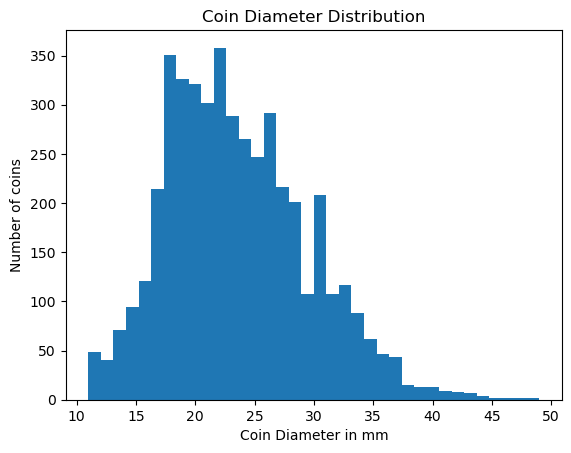

In [108]:
plt.hist(x=roman_coins.query("diameter > 10 and diameter < 50")['diameter'].dropna(), bins=36)
plt.title('Coin Diameter Distribution'); plt.xlabel('Coin Diameter in mm'); plt.ylabel('Number of coins')
plt.show()

#### Precursory glance at the correlation between mass and diameter, grouped by metal

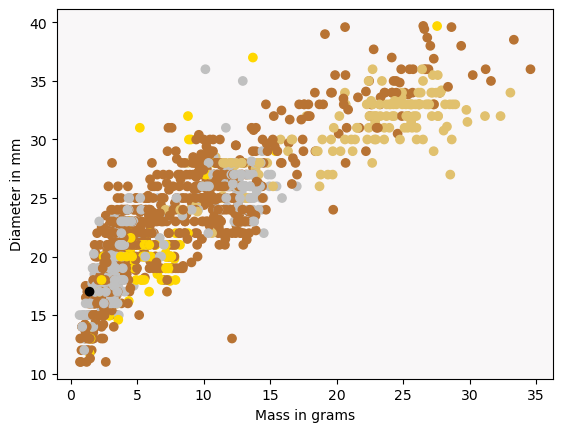

In [143]:
mass_diameter = roman_coins_mass.query("diameter > 10 and diameter < 40 and mass < 35").dropna(subset=['metal', 'diameter'])
colors = {'Gold':'gold', 'Copper':'#B87333', 'Silver':'silver', 'Brass':'#E1C16E', 'FAKE':'black'}
ax = plt.axes(); ax.set_facecolor('#F9F7F8')
plt.scatter(x=mass_diameter['mass'], y=mass_diameter['diameter'], c=mass_diameter['metal'].map(colors))
plt.xlabel('Mass in grams'); plt.ylabel('Diameter in mm')
plt.show()

### run code chunk below to save new Dataframe as csv files

In [68]:
roman_coins_raw.to_csv('roman_coins_raw.csv')
roman_coins.to_csv('roman_coins.csv')
roman_coins_years.to_csv('roman_coins_years.csv')
roman_coins_mass.to_csv('roman_coins_mass.csv')

## Create Dataframe for just titles and subtitles 
(since subtitles are often too long to fit comfortably in a Dataframe - useful for later joins if subtitles are desired)

In [84]:
# titles_and_subtitles = 
    